In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from numpy import pi
import xarray as xr
from xgcm import Grid

import crocosi.postp as pp
import crocosi.gridop as gop
import crocosi.vmodes as vmd

In [39]:
### Load simulation

root_path = '/home/datawork-lops-osi/equinox/jetn/'
run = 'jet_cfg1_wp8_m1a1_4km_500a1000j/'
    
it = 1 # time index (working with one time index for this example)

r = pp.Run(root_path+run, prefix='', outputs=['grid','his'], verbose=False)
ds = r['his'].isel(time=it)

In [40]:
### select portion of dataset
sliy = slice(0, 2880*1e3)
sds = ds.sel(y_rho=sliy)

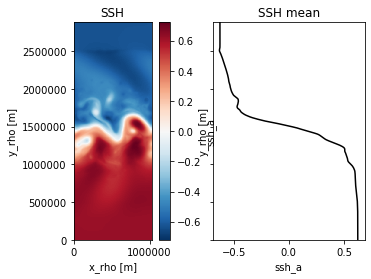

In [41]:
### compute and plot mean ssh (and vertical levels)
ssh_mean = sds.ssh_a.mean(dim='x_rho')
h_mean = r['grid'].h.sel(y_rho=sliy).mean(dim="x_rho")
    
fig, axs = plt.subplots(1, 2, sharey=True)
sds.ssh_a.plot(ax=axs[0])
ssh_mean.plot(ax=axs[1], y="y_rho", color="k")
axs[0].set_aspect('equal')
axs[0].set_title('SSH')
axs[1].set_title('SSH mean')

# and compute mean vertical grids
zr_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='r', hgrid='r').persist()
zw_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='w', hgrid='r').persist()

Text(0.5, 1.0, 'mean N2')

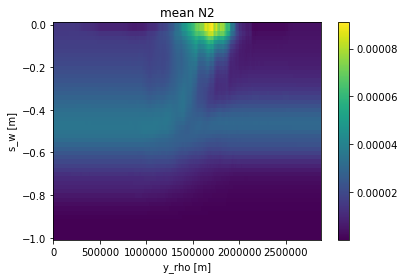

In [42]:
# compute mean stratification
z_rho = r.get_z(zeta=sds.ssh_a, vgrid="r", hgrid="r")
T_mean = gop.interp2z(zr_mean, z_rho, sds.T_a).mean("x_rho") # interpolate on mean grid
N2 = r.get_N2(T_mean, zr_mean).chunk({"s_w":-1}) # compute stratif
N2 = N2.assign_coords(z_w=zw_mean).persist()

### plot result    
N2.plot(y="s_w")
plt.title("mean N2")

Vmode object with dimensions ('mode', 's_rho', 's_w', 'y_rho')
  Number of modes = 3
  N2, min/max = 9.8e-08, 9.1e-05
  Options / parameters: g=9.81, free_surf=True, eig_sigma=1.0e-01

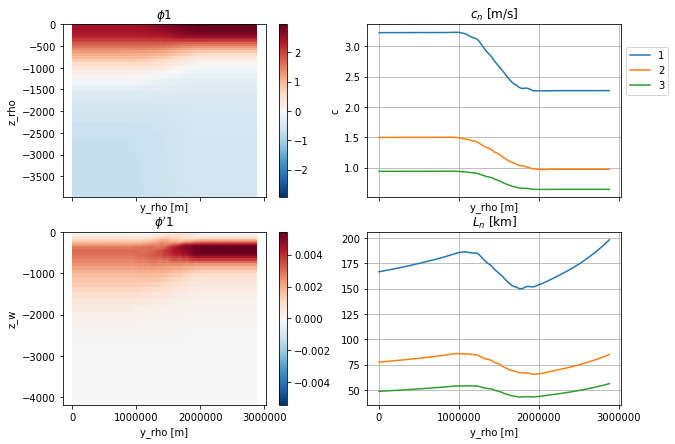

In [43]:
### compute modes
nmodes = 3

# create xgcm grid
gridcoord = {key:val.coords for key,val in r.xgrid.axes.items() if key not in "xi"}
xgrid = Grid(sds, coords=gridcoord, periodic=['eta'])
    
vmodes = vmd.Vmodes(xgrid, zr_mean, zw_mean, N2, nmodes, persist=True) # working version
omega = 2.*pi/(12.*3600)
lwave = 2*pi*vmodes["c"] / (omega**2 - vmodes["f"]**2)**.5 *1e-3 # horizontal lengthscale [km]

# plot result (for one mode)
imod = 1
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(10,7))

vmodes.ds.phi.sel(mode=imod).plot(x="y_rho", y="z_rho", ax=axs[0,0], cbar_kwargs={"label":""})
axs[0,0].set_title(r"$\phi $"+str(imod))

vmodes.ds.dphidz.sel(mode=imod).plot(x="y_rho", y="z_w", ax=axs[1,0], cbar_kwargs={"label":""})
axs[1,0].set_title(r"$\phi' $"+str(imod))

hpl = vmodes.ds.c.isel(mode=slice(1,None)).plot.line(x="y_rho", ax=axs[0,1], add_legend=False)
axs[0,1].grid(True)
axs[0,1].set_title(r"$c_n$ [m/s]")
axs[0, 1].legend(hpl, vmodes['mode'][1:].values, bbox_to_anchor=(1,.9))

lwave.isel(mode=slice(1,None)).plot.line(x="y_rho", ax=axs[1,1], add_legend=False)
axs[1,1].grid(True)
axs[1,1].set_title(r"$L_n$ [km]")

# show result
vmodes

In [44]:
R = xr.Dataset(data_vars={'cn':vmodes.ds.c,'lwave':lwave,'N2':N2})

In [45]:
R

<xarray.Dataset>
Dimensions:       (mode: 4, s_w: 51, y_rho: 720)
Coordinates:
  * y_rho         (y_rho) float32 2000.0 6000.0 10000.0 ... 2874000.0 2878000.0
    f             (y_rho) float32 7.985453e-05 7.991927e-05 ... 0.00012640547
    f_rho         (y_rho) float32 7.985453e-05 7.991927e-05 ... 0.00012640547
    y_u           (y_rho) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    time_instant  float64 dask.array<chunksize=(), meta=np.ndarray>
    time_counter  float64 540.0
  * mode          (mode) int64 0 1 2 3
  * s_w           (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
    z_w           (s_w, y_rho) float32 dask.array<chunksize=(51, 720), meta=np.ndarray>
Data variables:
    cn            (mode, y_rho) float64 dask.array<chunksize=(4, 720), meta=np.ndarray>
    lwave         (mode, y_rho) float64 dask.array<chunksize=(4, 720), meta=np.ndarray>
    N2            (y_rho, s_w) float64 dask.array<chunksize=(720, 51), meta=np.ndarray>

In [46]:
#store
r.store_diagnostic('ZC_waves_modes', R, overwrite=True,file_format='netcdf')

data stored in /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp8_m1a1_4km_500a1000j/diagnostics/ZC_waves_modes.nc
